# Binary classification - single_model using Naive Bayes(semeval)

# Importing and Preprocessing

## Importing libraries

In [68]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

## Importing files

In [69]:
original_data = pd.read_csv('../dataset/Semeval_dataset/train_semeval.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'reference_answer':'ref_answer'})

## Preprocessing

In [70]:
df = original_data.copy()
#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

# Gathering required features

In [71]:
short_df = df[['question','student_answer','student_modified','ref_modified' ,'grade']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)

# FOR ONE BY ONE QUESTION
# short_df = short_df[short_df['question_id'] == ques_id_list[0]]
# ques_id_list.pop(0)
# ques_id_list
# ======================

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Bag of words

In [72]:
# short_df['word_count'] = short_df['student_answer'].apply(lambda x: dict(Counter(x.split())))

# counting unique words in every student's answer
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = short_df['status'].values

# Seeding

In [73]:
#getting the seed index
classes = short_df['status'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['status'][short_df['status']==i].index[0])
seed_index

[0, 1]

In [74]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = MultinomialNB()
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/10)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X,Y))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.764398
Accuracy after query no. 2: 0.288016
Accuracy after query no. 3: 0.277196
Accuracy after query no. 4: 0.300625
Accuracy after query no. 5: 0.700322
Accuracy after query no. 6: 0.700464
Accuracy after query no. 7: 0.298589
Accuracy after query no. 8: 0.299456
Accuracy after query no. 9: 0.299314
Accuracy after query no. 10: 0.328424
Accuracy after query no. 11: 0.327885
Accuracy after query no. 12: 0.321292
Accuracy after query no. 13: 0.318732
Accuracy after query no. 14: 0.342015
Accuracy after query no. 15: 0.333401
Accuracy after query no. 16: 0.330034
Accuracy after query no. 17: 0.303838
Accuracy after query no. 18: 0.344716
Accuracy after query no. 19: 0.338116
Accuracy after query no. 20: 0.369517
Accuracy after query no. 21: 0.422766
Accuracy after query no. 22: 0.429929
Accuracy after query no. 23: 0.454693
Accuracy after query no. 24: 0.474408
Accuracy after query no. 25: 0.474100
Accuracy after query no. 26: 0.468731
Accuracy after query 

Accuracy after query no. 214: 0.769409
Accuracy after query no. 215: 0.769360
Accuracy after query no. 216: 0.771417
Accuracy after query no. 217: 0.771158
Accuracy after query no. 218: 0.766477
Accuracy after query no. 219: 0.766639
Accuracy after query no. 220: 0.765957
Accuracy after query no. 221: 0.766330
Accuracy after query no. 222: 0.766702
Accuracy after query no. 223: 0.764966
Accuracy after query no. 224: 0.766182
Accuracy after query no. 225: 0.765711
Accuracy after query no. 226: 0.766294
Accuracy after query no. 227: 0.766456
Accuracy after query no. 228: 0.766406
Accuracy after query no. 229: 0.766779
Accuracy after query no. 230: 0.767152
Accuracy after query no. 231: 0.768159
Accuracy after query no. 232: 0.767476
Accuracy after query no. 233: 0.767638
Accuracy after query no. 234: 0.767801
Accuracy after query no. 235: 0.767963
Accuracy after query no. 236: 0.768125
Accuracy after query no. 237: 0.768288
Accuracy after query no. 238: 0.768027
Accuracy after query no. 

Accuracy after query no. 426: 0.788152
Accuracy after query no. 427: 0.788326
Accuracy after query no. 428: 0.788500
Accuracy after query no. 429: 0.788233
Accuracy after query no. 430: 0.788406
Accuracy after query no. 431: 0.789021
Accuracy after query no. 432: 0.788754
Accuracy after query no. 433: 0.789369
Accuracy after query no. 434: 0.789102
Accuracy after query no. 435: 0.789276
Accuracy after query no. 436: 0.790113
Accuracy after query no. 437: 0.790066
Accuracy after query no. 438: 0.790241
Accuracy after query no. 439: 0.789973
Accuracy after query no. 440: 0.790148
Accuracy after query no. 441: 0.788113
Accuracy after query no. 442: 0.788066
Accuracy after query no. 443: 0.788019
Accuracy after query no. 444: 0.788415
Accuracy after query no. 445: 0.788368
Accuracy after query no. 446: 0.788100
Accuracy after query no. 447: 0.787832
Accuracy after query no. 448: 0.788006
Accuracy after query no. 449: 0.788181
Accuracy after query no. 450: 0.788576
Accuracy after query no. 

## Regular supervised task

## Importing test data

In [75]:
original_data = pd.read_csv('../dataset/Semeval_dataset/test1_semeval.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'reference_answer':'ref_answer'})
df = original_data.copy()
#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
short_df = df[['question','student_answer','student_modified','ref_modified' ,'grade']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)
# counting unique words in every student's answer
student_answer_count_vector = CV.transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X_test = student_answer_count_vector
Y_test = short_df['status'].values 
# Y_test = np.reshape(Y_test, (-1, 1))
X_train = np.copy(X)
Y_train = np.copy(Y)
X_test.shape

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(540, 1908)

In [81]:
# logisticRegr = LogisticRegression()
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, Y_train)
score = naive_bayes.score(X_test, Y_test)

print(score)

0.7777777777777778


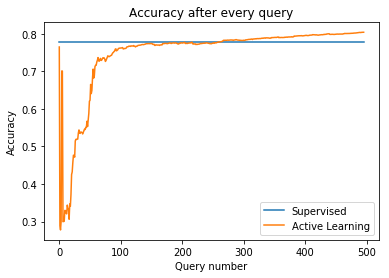

In [82]:
supervised_accuracy = [score for x in range(0,n_queries)]

plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()

In [83]:
score = learner.score(X_test, Y_test)
score

0.7592592592592593